In [35]:
%matplotlib inline

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp

# Generating Data

In [37]:
N = 10000

household_income = np.random.gamma(50, 1000, size=N)  # Z1, in USD. probably unrealistic, 
                                                      # since not long-tailed enough
parents_education = np.random.choice(range(5), size=N)  # Z2, labels ['no high school', high school', 'some college', 'BA/BS', 
                                                        #             'post-grad degree']
last_year_gpa = np.random.uniform(2.0, 4.0, size=N)  # Z3 on a 4-point scale, 
                                                     # assuming everyone passed last year
commute_time = np.random.gamma(1, 1, size=N)  # Z4, in hours
hobby_engagement = np.random.gamma(2, 1, size=N) # Z5, in hours per week

df = pd.DataFrame({'household_income': household_income,
                   'parents_education': parents_education,
                   'last_year_gpa': last_year_gpa,
                   'commute_time': commute_time,
                   'hobby_engagement': hobby_engagement})


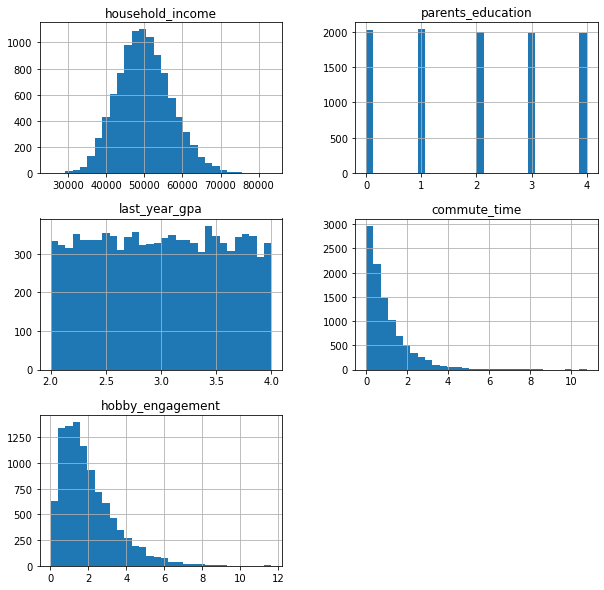

In [38]:
df.hist(figsize=(10,10), bins=30);

In [39]:
beta_ca = 1.
beta_ha = -1.
beta_ia = 1.
beta_ga = -1.
beta_ea = 1.
beta_a = -3

phi = beta_ca * df['commute_time'] / df['commute_time'].std() + \
      beta_ha * df['hobby_engagement'] / df['hobby_engagement'].std()+ \
      beta_ia * df['household_income'] / df['household_income'].std()+ \
      beta_ga * df['last_year_gpa'] / df['last_year_gpa'].std() + \
      beta_ea * df['parents_education'] / df['parents_education'].std() + \
      beta_a
p_app = 1. / (1. + np.exp(-phi))
df['uses_app'] = np.random.binomial(1., p=p_app)

In [40]:
df.mean()

household_income     50053.672848
parents_education        1.986900
last_year_gpa            2.997884
commute_time             0.996932
hobby_engagement         2.000660
uses_app                 0.478800
dtype: float64

In [41]:
df.corr()

,household_income,parents_education,last_year_gpa,commute_time,hobby_engagement,uses_app
household_income,1.000000,0.002690,0.003546,-0.000273,0.000572,0.283851
parents_education,0.002690,1.000000,-0.000262,-0.011846,0.017499,0.283276
last_year_gpa,0.003546,-0.000262,1.000000,-0.016909,0.023108,-0.313443
commute_time,-0.000273,-0.011846,-0.016909,1.000000,-0.009801,0.260051
hobby_engagement,0.000572,0.017499,0.023108,-0.009801,1.000000,-0.269804
uses_app,0.283851,0.283276,-0.313443,0.260051,-0.269804,1.000000


In [42]:
beta_cp = -1.
beta_hp = -1.
beta_ip = 1.
beta_gp = 8.
beta_p = -50
beta_ep = 1.

delta = 0.1

phi_p = beta_cp * df['commute_time'] / df['commute_time'].std() + \
        beta_hp * df['hobby_engagement'] / df['hobby_engagement'].std()+ \
        beta_ip * df['household_income'] / df['household_income'].std()+ \
        beta_gp * df['last_year_gpa'] / df['last_year_gpa'].std() + \
        beta_ep * df['parents_education'] / df['parents_education'].std() + \
        beta_p
p_passes = np.minimum(1. / (1. + np.exp(-phi_p/5)), 1. - delta - 0.001) + df['uses_app']*delta
df['passes'] = np.random.binomial(1., p=p_passes)

<AxesSubplot:>

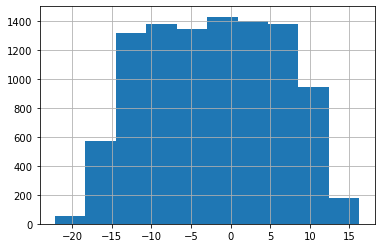

In [43]:
phi_p.hist()

In [44]:
df.mean()

household_income     50053.672848
parents_education        1.986900
last_year_gpa            2.997884
commute_time             0.996932
hobby_engagement         2.000660
uses_app                 0.478800
passes                   0.477800
dtype: float64

In [45]:
df.corr()

,household_income,parents_education,last_year_gpa,commute_time,hobby_engagement,uses_app,passes
household_income,1.000000,0.002690,0.003546,-0.000273,0.000572,0.283851,0.080892
parents_education,0.002690,1.000000,-0.000262,-0.011846,0.017499,0.283276,0.097079
last_year_gpa,0.003546,-0.000262,1.000000,-0.016909,0.023108,-0.313443,0.548470
commute_time,-0.000273,-0.011846,-0.016909,1.000000,-0.009801,0.260051,-0.037824
hobby_engagement,0.000572,0.017499,0.023108,-0.009801,1.000000,-0.269804,-0.069745
uses_app,0.283851,0.283276,-0.313443,0.260051,-0.269804,1.000000,-0.048374
passes,0.080892,0.097079,0.548470,-0.037824,-0.069745,-0.048374,1.000000


In [46]:
## Let's check the naive estimate

df.groupby('uses_app').mean()['passes'][1] - df.groupby('uses_app').mean()['passes'][0]

-0.04836951678249091

Looks like the effect is biased, from its true value of 0.1 percentage points.

Now, let's try exact matching. First, we should pre-process our continuous variables into discrete variables.

# PS Matching

## Performing Matching

In [47]:
matching_variables = ['household_income',
                      'parents_education',
                      'last_year_gpa',
                      'commute_time',
                      'hobby_engagement']

In [48]:
from statsmodels.discrete.discrete_model import Logit


df['intercept'] = 1
model = Logit(endog=df['passes'], 
              exog=df[matching_variables])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.594231
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 passes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Tue, 09 Feb 2021   Pseudo R-squ.:                  0.1415
Time:                        21:11:31   Log-Likelihood:                -5942.3
converged:                       True   LL-Null:                       -6921.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
household_income  -7.278e-05   2.19e-06    -33.297      0.000   -7.71e-05   -6.85e-05
parents_education     0.0727      0.015      4.692      0.000       0.042       0.103
last_year_gpa         1.3776      0.036     38.017      0.000       1.307       1.449
commute_time         -0.1791      0.022     -8.026      0.000      -0.223      -0.135
hobby_engagement     -0.2320      0.016    -14.633      0.000      -0.263      -0.201
=====================================================================================
"""

In [49]:
df['propensity_score'] = result.predict()

In [50]:
from sklearn.neighbors import NearestNeighbors


control_students = df[df.uses_app == 0]
test_students = df[df.uses_app == 1]

control_nn = NearestNeighbors(n_neighbors=1)
control_nn = control_nn.fit(control_students[['propensity_score']].values)
test_nn = NearestNeighbors(n_neighbors=1)
test_nn = test_nn.fit(test_students[['propensity_score']].values)

In [51]:
def choose_match(row):
    if row['uses_app'] == 1:
        match_distances, match_indices = control_nn.kneighbors([row[['propensity_score']].values])
        matches = control_students.iloc[match_indices[0]]
    else:
        match_distances, match_indices = test_nn.kneighbors([row[['propensity_score']].values])
        matches = test_students.iloc[match_indices[0]]
    match = matches.sample(n=1)
    return match['passes'].values[0]

df['matched_outcome'] = df.apply(choose_match, axis=1)

In [52]:
y1 = df['uses_app']*df['passes'] + (1. - df['uses_app'])*df['matched_outcome']
y0 = (1-df['uses_app'])*df['passes'] + (df['uses_app'])*df['matched_outcome']
(y1 - y0).mean()

0.1024

In [53]:
N = 1000
k = 1

samples = 200
df_true = df.copy()
results = []
for _ in range(samples):
    df = df_true.sample(n=len(df), replace=True)
    model = Logit(endog=df['passes'], exog=df[matching_variables])
    result = model.fit()
    df['propensity_score'] = result.predict()

    control_students = df[df.uses_app == 0]
    test_students = df[df.uses_app == 1]

    control_nn = NearestNeighbors(n_neighbors=k)
    control_nn = control_nn.fit(control_students[['propensity_score']].values)
    test_nn = NearestNeighbors(n_neighbors=k)
    test_nn = test_nn.fit(test_students[['propensity_score']].values)


    def choose_match(row):
        if row['uses_app'] == 1:
            match_distances, match_indices = control_nn.kneighbors([row[['propensity_score']].values])
            matches = control_students.iloc[match_indices[0]]
        else:
            match_distances, match_indices = test_nn.kneighbors([row[['propensity_score']].values])
            matches = test_students.iloc[match_indices[0]]
        #match = matches.sample(n=k)
        return matches['passes'].mean()#match['passes'].mean()#.values[0]

    df['matched_outcome'] = df.apply(choose_match, axis=1)

    y1 = df['uses_app']*df['passes'] + (1. - df['uses_app'])*df['matched_outcome']
    y0 = (1-df['uses_app'])*df['passes'] + (df['uses_app'])*df['matched_outcome']
    result = (y1 - y0).mean()
    results.append(result)

Optimization terminated successfully.
         Current function value: 0.591703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.589861
  

Optimization terminated successfully.
         Current function value: 0.594146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601209
  

Optimization terminated successfully.
         Current function value: 0.596293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.593743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595279
  

In [88]:
results = pd.Series(results)
results.describe()

count    200.000000
mean       0.102879
std        0.023026
min        0.031300
25%        0.088275
50%        0.100950
75%        0.118300
max        0.175200
dtype: float64

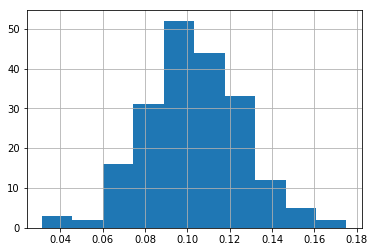

In [89]:
results.hist()